In [1]:
import numpy as np
import random
import os
import scipy
import pickle
from skimage.segmentation import slic
from torchvision import datasets
import multiprocessing as mp
import scipy.ndimage
import scipy.spatial
import argparse
import datetime
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage import segmentation,color

def parse_args():
    parser = argparse.ArgumentParser(description='Extract SLIC superpixels from images')
    parser.add_argument('-D', '--dataset', type=str, default='lungs', choices=['lungs'])
    parser.add_argument('-d', '--data_dir', type=str, default='./data', help='path to the dataset')
    parser.add_argument('-o', '--out_dir', type=str, default='./data', help='path where to save superpixels')
    parser.add_argument('-s', '--split', type=str, default='train', choices=['train', 'val', 'test'])
    parser.add_argument('-t', '--threads', type=int, default=-1, help='number of parallel threads')
    #Default is set to get the number of superpixel per image
    parser.add_argument('-n', '--n_sp', type=int, default=75, help='max number of superpixels per image') 
    # Default is set to 0.125 for best outcome
    parser.add_argument('-c', '--compactness', type=int, default=0.125, help='compactness of the SLIC algorithm '
                                                                      '(Balances color proximity and space proximity):') 
    parser.add_argument('--seed', type=int, default=111, help='seed for shuffling nodes')
    args,unknown = parser.parse_known_args() #changed args = parser.parse_args()

    for arg in vars(args):
        print(arg, getattr(args, arg))

    return args

def show_image(image):
  width = 10
  height = image.shape[0] * width / image.shape[1]
  f = plt.figure(figsize=(width,height))
  plt.imshow(image,cmap='gray')
  plt.axis("off")


In [2]:
def process_image(params):
    
    img, index, n_images, args, to_print, shuffle = params

    assert img.dtype == np.uint8, img.dtype
    img = (img / 255.).astype(np.double)
 # number of actually extracted superpixels (can be different from requested in SLIC)
    n_sp_extracted = args.n_sp + 1 
    n_sp_query = args.n_sp + (50 if args.dataset == 'lungs' else 50)  # number of superpixels we ask to extract (larger to extract more superpixels - closer to the desired n_sp) changed to 100
    while n_sp_extracted > args.n_sp:
        superpixels = slic(img, n_segments=n_sp_query, compactness=args.compactness, multichannel=len(img.shape) > 2)
        sp_indices = np.unique(superpixels)
        n_sp_extracted = len(sp_indices)
        n_sp_query -= 1  # reducing the number of superpixels until we get <= n superpixels

    assert n_sp_extracted <= args.n_sp and n_sp_extracted > 0, (args.split, index, n_sp_extracted, args.n_sp)
    assert n_sp_extracted == np.max(superpixels) + 1, ('superpixel indices', np.unique(superpixels))  # make sure superpixel indices are numbers from 0 to n-1

    if shuffle:
        ind = np.random.permutation(n_sp_extracted)
    else:
        ind = np.arange(n_sp_extracted)

    sp_order = sp_indices[ind].astype(np.int32)
    if len(img.shape) == 2:
        img = img[:, :, None]

    n_ch = 1 if img.shape[2] == 1 else 3

    sp_intensity, sp_coord = [], []
    for seg in sp_order:
        mask = (superpixels == seg).squeeze()
        avg_value = np.zeros(n_ch)
        for c in range(n_ch):
            avg_value[c] = np.mean(img[:, :, c][mask])
        cntr = np.array(scipy.ndimage.measurements.center_of_mass(mask))  # row, col
        sp_intensity.append(avg_value)
        sp_coord.append(cntr)
    sp_intensity = np.array(sp_intensity, np.float32)
    sp_coord = np.array(sp_coord, np.float32)
    if to_print:
        print('image={}/{}, shape={}, min={:.2f}, max={:.2f}, n_sp={}'.format(index + 1, n_images, img.shape,
                                                                              img.min(), img.max(), sp_intensity.shape[0]))

    return sp_intensity, sp_coord, sp_order, superpixels




* Creating a 2 dimensional array with one representing array of image and second representing label.
* The whole dataset has to be split into training and testing dataset. 

In [3]:
from numpy import asarray
from PIL import Image

path_to_files = "data/Output Segmentation/CombinedDataset"
dataset = []

for i,image in enumerate(os.listdir(path_to_files)):
    img = Image.open(os.path.join(path_to_files,image))
    if image.split('.')[0][-1] == '0':
        dataset.append([asarray(img),0])
    else:
        dataset.append([asarray(img),1])


In [4]:
from numpy import asarray
from PIL import Image

path_to_files = "data/Output Segmentation/CombinedDataset"
positive = 0
negative = 0

for i,image in enumerate(os.listdir(path_to_files)):
    if image.split('.')[0][-1] == '0':
        negative += 1
    else:
        positive += 1

print(f"The total positive cases in my dataset {positive}.\n The total negative cases in my dataset {negative}")


The total positive cases in my dataset 452.
 The total negative cases in my dataset 359


In [8]:
import torch

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [6]:
dt = datetime.datetime.now()
print('start time:', dt)

args = parse_args()

if not os.path.isdir(args.out_dir):
        os.mkdir(args.out_dir)

random.seed(args.seed)
np.random.seed(args.seed)  # to make node random permutation reproducible (not tested)


if(args.split.lower() == 'train'):

        images = [train_dataset[i][0] for i in range(len(train_dataset))]
        labels = [train_dataset[i][1] for i in range(len(train_dataset))]

        images = np.array(images)

        if not isinstance(images, np.ndarray):
                images = images.numpy()
        if isinstance(labels, list):
                labels = np.array(labels)
        if not isinstance(labels, np.ndarray):
                labels = labels.numpy()

        n_images = len(labels)

        if args.threads <= 0:
                sp_data = []
                for i in range(n_images):
                        sp_data.append(process_image((images[i], i, n_images, args, True, True)))
        else:
                with mp.Pool(processes=args.threads) as pool:
                        sp_data  = pool.map(process_image, [(images[i], i, n_images, args, True, True) for i in range(n_images)])

        superpixels = [sp_data[i][3] for i in range(n_images)] #All superpixel stored in 3rd index into superpixels variable.
        sp_data = [sp_data[i][:3] for i in range(n_images)]     #sp_intensity, sp_coord, sp_order stored in sp_data variable.

        with open('%s/%s_%dnew_lungs_sp_%s.pkl' % (args.out_dir, args.dataset, args.n_sp, args.split), 'wb') as f:
                pickle.dump((labels.astype(np.int32), sp_data), f, protocol=2) #Store sp_data and labels into pickle file.

        # with open('%s/%s_%dnew_lungs_sp_%s_superpixels.pkl' % (args.out_dir, args.dataset, args.n_sp, args.split), 'wb') as f:
        #         pickle.dump(superpixels, f, protocol=2) #Store superpixels of each images formed through this process into this pickle file.

        print('done in {}'.format(datetime.datetime.now() - dt))

start time: 2023-08-30 16:03:17.636147
dataset lungs
data_dir ./data
out_dir ./data
split train
threads -1
n_sp 75
compactness 0.125
seed 111
image=1/648, shape=(512, 512, 1), min=0.00, max=0.96, n_sp=73
image=2/648, shape=(512, 512, 1), min=0.00, max=0.84, n_sp=74
image=3/648, shape=(512, 512, 1), min=0.00, max=0.95, n_sp=75
image=4/648, shape=(512, 512, 1), min=0.00, max=0.97, n_sp=66
image=5/648, shape=(512, 512, 1), min=0.00, max=0.98, n_sp=67
image=6/648, shape=(512, 512, 1), min=0.00, max=0.97, n_sp=75
image=7/648, shape=(512, 512, 1), min=0.00, max=0.93, n_sp=72
image=8/648, shape=(512, 512, 1), min=0.00, max=0.99, n_sp=75
image=9/648, shape=(512, 512, 1), min=0.00, max=0.96, n_sp=75
image=10/648, shape=(512, 512, 1), min=0.00, max=0.82, n_sp=60
image=11/648, shape=(512, 512, 1), min=0.00, max=0.99, n_sp=72
image=12/648, shape=(512, 512, 1), min=0.00, max=0.95, n_sp=75
image=13/648, shape=(512, 512, 1), min=0.00, max=0.98, n_sp=71
image=14/648, shape=(512, 512, 1), min=0.00, max

In [9]:
args.split = 'test'
if(args.split.lower() == 'test'):

    images = [test_dataset[i][0] for i in range(len(test_dataset))]
    labels = [test_dataset[i][1] for i in range(len(test_dataset))]

    images = np.array(images)

    if not isinstance(images, np.ndarray):
        images = images.numpy()
    if isinstance(labels, list):
        labels = np.array(labels)
    if not isinstance(labels, np.ndarray):
        labels = labels.numpy()

    n_images = len(labels)

    if args.threads <= 0:
        sp_data = []
        for i in range(n_images):
            sp_data.append(process_image((images[i], i, n_images, args, True, True)))
    else:
        with mp.Pool(processes=args.threads) as pool:
            sp_data  = pool.map(process_image, [(images[i], i, n_images, args, True, True) for i in range(n_images)])

    superpixels = [sp_data[i][3] for i in range(n_images)] #All superpixel stored in 3rd index into superpixels variable.
    sp_data = [sp_data[i][:3] for i in range(n_images)]     #sp_intensity, sp_coord, sp_order stored in sp_data variable.

    with open('%s/%s_%dnew_lungs_sp_%s.pkl' % (args.out_dir, args.dataset, args.n_sp, args.split), 'wb') as f:
        pickle.dump((labels.astype(np.int32), sp_data), f, protocol=2) #Store sp_data and labels into pickle file.

    with open('%s/%s_%dnew_lungs_sp_%s_superpixels.pkl' % (args.out_dir, args.dataset, args.n_sp, args.split), 'wb') as f:
        pickle.dump(superpixels, f, protocol=2) #Store superpixels of each images formed through this process into this pickle file.

    print('done in {}'.format(datetime.datetime.now() - dt))

image=1/163, shape=(512, 512, 1), min=0.00, max=0.99, n_sp=70
image=2/163, shape=(512, 512, 1), min=0.00, max=0.93, n_sp=71
image=3/163, shape=(512, 512, 1), min=0.00, max=0.82, n_sp=60
image=4/163, shape=(512, 512, 1), min=0.00, max=0.96, n_sp=73
image=5/163, shape=(512, 512, 1), min=0.00, max=0.96, n_sp=74
image=6/163, shape=(512, 512, 1), min=0.00, max=0.96, n_sp=73
image=7/163, shape=(512, 512, 1), min=0.00, max=0.93, n_sp=74
image=8/163, shape=(512, 512, 1), min=0.00, max=0.93, n_sp=73
image=9/163, shape=(512, 512, 1), min=0.00, max=0.94, n_sp=63
image=10/163, shape=(512, 512, 1), min=0.00, max=0.94, n_sp=68
image=11/163, shape=(512, 512, 1), min=0.00, max=0.99, n_sp=72
image=12/163, shape=(512, 512, 1), min=0.00, max=0.91, n_sp=72
image=13/163, shape=(512, 512, 1), min=0.00, max=0.98, n_sp=75
image=14/163, shape=(512, 512, 1), min=0.00, max=0.94, n_sp=74
image=15/163, shape=(512, 512, 1), min=0.00, max=0.94, n_sp=73
image=16/163, shape=(512, 512, 1), min=0.00, max=0.93, n_sp=75
i

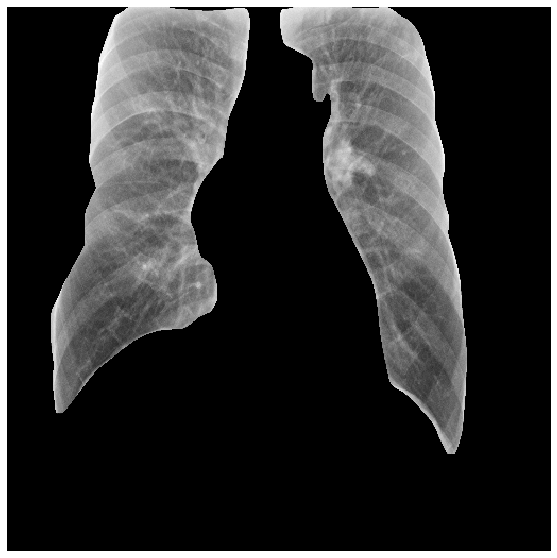

In [10]:
show_image(images[10])
# plt.savefig('images/segmented_lungs_1.png',format='png',bbox_inches='tight',pad_inches=0)

The corresponding label:  1


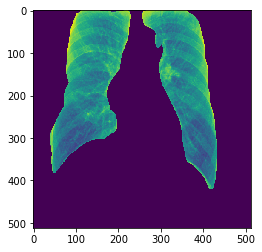

In [13]:
plt.imshow(images[10])
print("The corresponding label: ",labels[10])

In [14]:
sp_intensity, sp_coord, sp_order, superpixels = process_image((images[10], 10, n_images, args, True, True))

print('sp_intensity: {}, sp_coord: {}", "sp_order": {}, "superpixels: {}'.format(len(sp_intensity), len(sp_coord), len(sp_order), len(superpixels)))

image=11/163, shape=(512, 512, 1), min=0.00, max=0.99, n_sp=72
sp_intensity: 72, sp_coord: 72", "sp_order": 72, "superpixels: 512


In [15]:
print(len(superpixels[0]))

512


In [16]:
print("super_pixel size: ",superpixels.size)
print("image_size: ",images[10].size)

super_pixel size:  262144
image_size:  262144


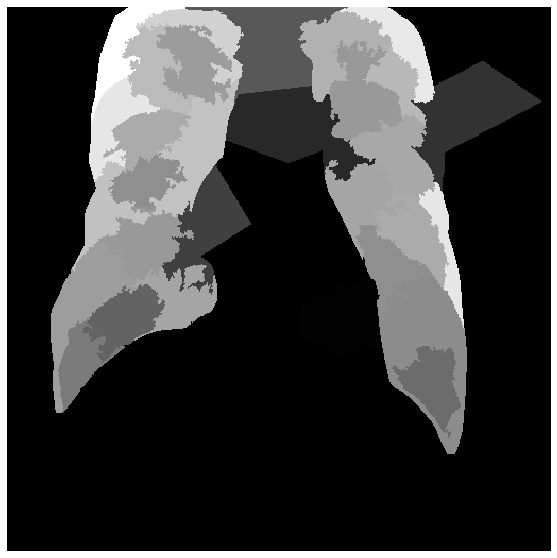

In [17]:
color_label = color.label2rgb(superpixels, image=images[10],kind='avg')
show_image(color_label)
# plt.savefig('images/segmented_lungs_superpixel_noborder_1.png',format='png',bbox_inches='tight',pad_inches=0)

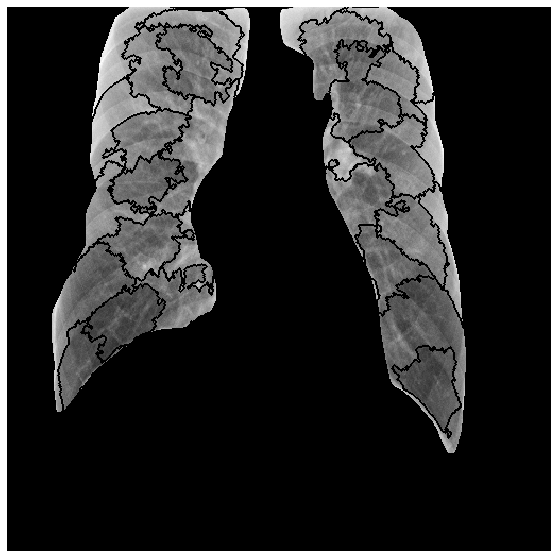

In [18]:
border_image = segmentation.mark_boundaries(images[10], superpixels, (0, 0, 0))
show_image(border_image)
plt.savefig('images/segmented_lungs_superpixel_border_1.png',format='png',bbox_inches='tight',pad_inches=0)

In [19]:
import random
from torchvision import transforms, datasets

import os
import pickle
from scipy.spatial.distance import cdist
from scipy import ndimage
import numpy as np

import dgl
import torch
import time
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib

Using backend: pytorch


In [20]:
import os
print("Current working directory: {0}".format(os.getcwd()))
# os.chdir('Graph Neural Network/my_gnn/data')
# os.chdir('../') # go to root folder of the project
print(os.getcwd())

Current working directory: c:\Users\Ronaj.Pradhan\Downloads\Superpixels in graph neural network
c:\Users\Ronaj.Pradhan\Downloads\Superpixels in graph neural network


In [21]:
# After finding the superpixel and each superpixel's intensity, co-ordinates, order we then convert these superpixel 
# images into graphs using the k-nearest-neighbour adjacency matrix, where i and j are the co-ordinates of superpixel
# and sigma is the scale parameter defined as the average distance d of the k-nearest neighbours for each node.


def sigma(dists, kth=8):
    # Get k-nearest neighbors for each node
    knns = np.partition(dists, kth, axis=-1)[:, kth::-1]

    # Compute sigma and reshape
    sigma = knns.sum(axis=1).reshape((knns.shape[0], 1))/kth
    return sigma + 1e-8 # adding epsilon to avoid zero value of sigma

def compute_adjacency_matrix_images(coord, feat, use_feat=False, kth=8):
    coord = coord.reshape(-1, 2)
    # Compute coordinate distance
    c_dist = cdist(coord, coord)
    
    if use_feat:
        # Compute feature distance
        f_dist = cdist(feat, feat)
        # Compute adjacency
        A = np.exp(- (c_dist/sigma(c_dist))**2 - (f_dist/sigma(f_dist))**2 )
    else:
        A = np.exp(- (c_dist/sigma(c_dist))**2)
        
    # Convert to symmetric matrix
    # A = 0.5 * (A + A.T)
    A = 0.5 * A * A.T
    A[np.diag_indices_from(A)] = 0
    return A

def compute_edges_list(A, kth=8+1):
    # Get k-similar neighbor indices for each node
    if 1==1:   
        num_nodes = A.shape[0]
        new_kth = num_nodes - kth
        knns = np.argpartition(A, new_kth-1, axis=-1)[:, new_kth:-1]
        knns_d = np.partition(A, new_kth-1, axis=-1)[:, new_kth:-1]
    else:
        knns = np.argpartition(A, kth, axis=-1)[:, kth::-1]
        knns_d = np.partition(A, kth, axis=-1)[:, kth::-1]
    return knns, knns_d

In [48]:
class MNISTSuperPix(torch.utils.data.Dataset):
    def __init__(self,
                 data_dir,
                 split,
                 use_mean_px=True,
                 use_coord=True,
                 use_feat_for_graph_construct=False,):

        self.split = split
        self.is_test = split.lower() in ['test', 'val']
        with open(os.path.join(data_dir, 'lungs_400new_lungs_sp_%s.pkl' % split), 'rb') as f:
            self.labels, self.sp_data = pickle.load(f)

        self.use_mean_px = use_mean_px
        self.use_feat_for_graph = use_feat_for_graph_construct
        self.use_coord = use_coord
        self.n_samples = len(self.labels)
        self.img_size = 512

    def precompute_graph_images(self):
        print('precompute all data for the %s set...' % self.split.upper())
        self.Adj_matrices, self.node_features, self.edges_lists = [], [], []
        for index, sample in enumerate(self.sp_data):
            mean_px, coord = sample[:2]
            coord = coord / self.img_size
            A = compute_adjacency_matrix_images(coord, mean_px, use_feat=self.use_feat_for_graph)
            edges_list, _ = compute_edges_list(A)
            N_nodes = A.shape[0]
            
            x = None
            if self.use_mean_px:
                x = mean_px.reshape(N_nodes, -1)
            if self.use_coord:
                coord = coord.reshape(N_nodes, 2)
                if self.use_mean_px:
                    x = np.concatenate((x, coord), axis=1)
                else:
                    x = coord
            if x is None:
                x = np.ones(N_nodes, 1)  # dummy features
            
            self.node_features.append(x)
            self.Adj_matrices.append(A)
            self.edges_lists.append(edges_list)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
        g = dgl.DGLGraph()
        g.add_nodes(self.node_features[index].shape[0])
        g.ndata['feat'] = torch.Tensor(self.node_features[index])
        for src, dsts in enumerate(self.edges_lists[index]):
            g.add_edges(src, dsts[dsts!=src])

        return g, self.labels[index]

In [49]:
use_feat_for_graph_construct = True
tt = time.time()
data_with_feat_knn = MNISTSuperPix("data/superpixels/", 
                             #split='test', 
                             split='train', 
                             use_feat_for_graph_construct=use_feat_for_graph_construct)

data_with_feat_knn.precompute_graph_images()
print("Time taken: {:.4f}s".format(time.time()-tt))

precompute all data for the TRAIN set...
Time taken: 6.2208s


In [50]:
use_feat_for_graph_construct = False
tt = time.time()
data_no_feat_knn = MNISTSuperPix("data/superpixels/", 
                             #split='test', 
                             split='train', 
                             use_feat_for_graph_construct=use_feat_for_graph_construct)

data_no_feat_knn.precompute_graph_images()
print("Time taken: {:.4f}s".format(time.time()-tt))

precompute all data for the TRAIN set...
Time taken: 3.8204s


Label:  1


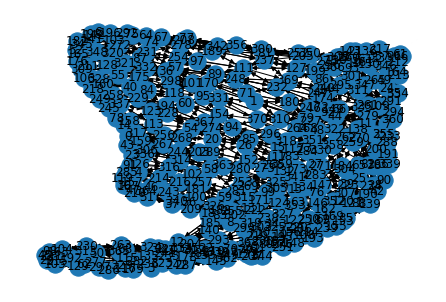

In [51]:
sample = np.random.choice(len(data_no_feat_knn))
g_sample = data_no_feat_knn[sample][0]
print("Label: ", data_no_feat_knn[sample][1])
nx.draw(g_sample.to_networkx(), with_labels=True)
plt.show()

In [52]:
data_no_feat_knn.__getitem__(sample)

(Graph(num_nodes=371, num_edges=2968,
       ndata_schemes={'feat': Scheme(shape=(3,), dtype=torch.float32)}
       edata_schemes={}), 1)

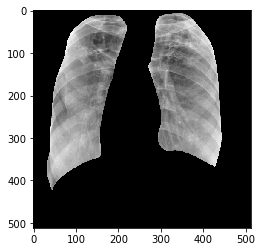

In [53]:
x, _ = dataset[10] # x is now a torch.Tensor
plt.imshow(np.array(x), cmap='gray')

In [54]:
from scipy.spatial.distance import pdist, squareform
from pylab import rcParams

def plot_superpixels_graph(plt, sp_data, adj_matrix, label, feat_coord, with_edges,idx):
    global node
    x, label = dataset[idx] # x is now a torch.Tensor
    img = np.array(x)

    y_lim, x_lim = img.shape[:]
    extent = 0, x_lim, 0, y_lim

    Y = squareform(pdist(sp_data[1], 'euclidean'))
    x_coord = sp_data[1] #np.flip(dataset.train.sp_data[_][1], 1)
    intensities = sp_data[0].reshape(-1)

    G = nx.from_numpy_matrix(Y)
    pos = dict(zip(range(len(x_coord)), x_coord.tolist()))
    rotated_pos = {node: (y,-x) for (node, (x,y)) in pos.items()} # rotate the coords by 90 degree
    
    edge_list = []
    for src, dsts in enumerate(compute_edges_list(adj_matrix)[0]):
        for dst in dsts:
            edge_list.append((src, dst))

    nx.draw_networkx_nodes(G, rotated_pos, node_color=intensities, cmap=matplotlib.cm.Reds, node_size=60,extent=extent) #len(intensities))
    if with_edges:
        nx.draw_networkx_edges(G, rotated_pos, edge_list, edge_color='r', alpha=0.3)

    

    title = "Label: " + str(label)
    if feat_coord:
        title += " | Using feat and coord for knn"
    else:
        title += " | Using only coord for knn"
    if not with_edges:
        title = "Label: " + str(label) + " | Only superpixel nodes"
    
    plt.title.set_text(title)
    # plt.show()
    # plt.savefig('x.png')
   
    
def show_image(plt, idx, alpha):
    x, label = dataset[idx] # x is now a torch.Tensor
    img = np.array(x)
    
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title.set_text("Label: " + str(label) + " | Original Image")

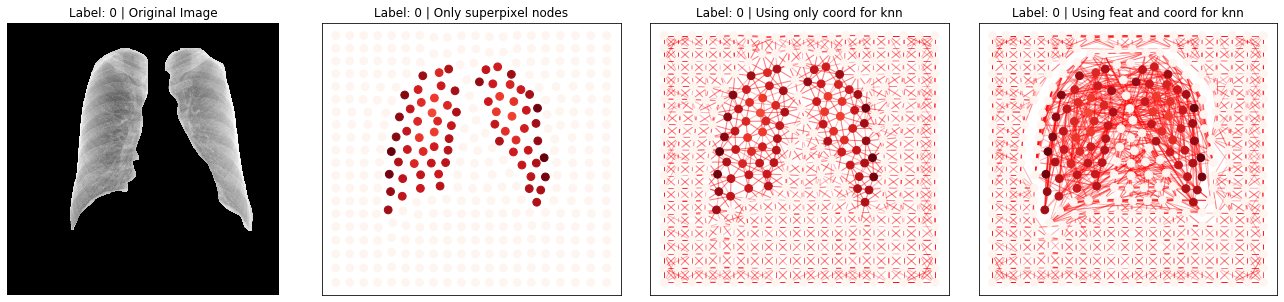

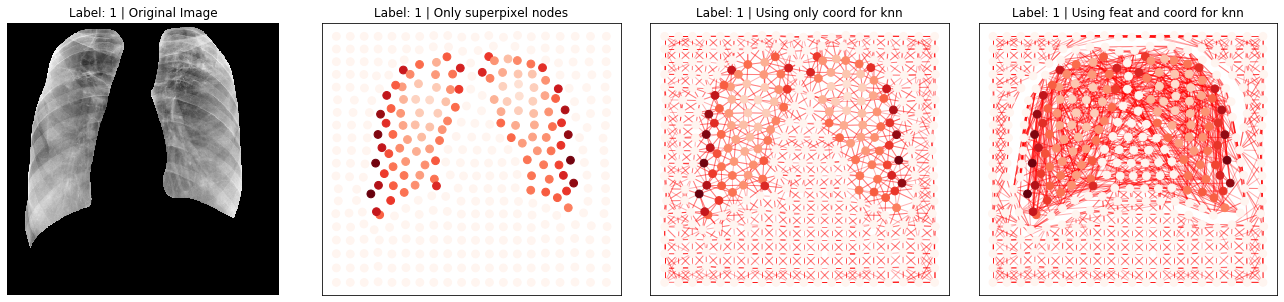

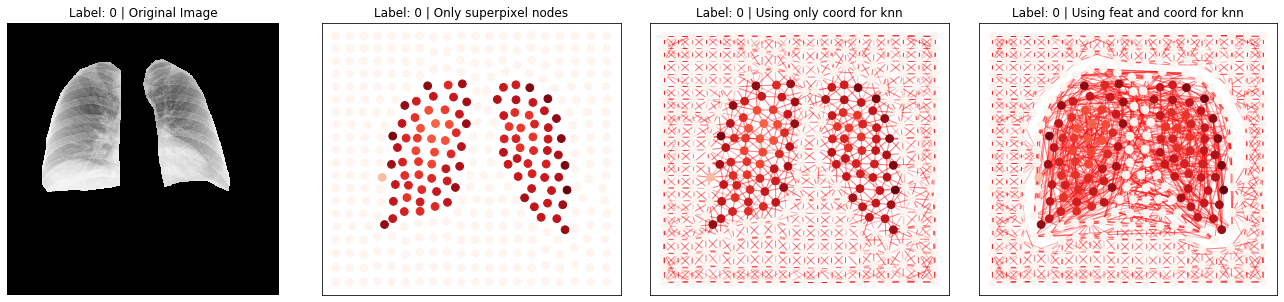

In [55]:
num_samples_plot = 3
for f_idx, idx in enumerate(np.random.choice(int(len(data_no_feat_knn)/2), num_samples_plot, replace=False)):
    f = plt.figure(f_idx, figsize=(23, 5))
    plt1 = f.add_subplot(141)
    show_image(plt1, idx, alpha=0.5)

    plt2 = f.add_subplot(142)  
    plot_superpixels_graph(plt2, data_no_feat_knn.sp_data[idx],
                           data_no_feat_knn.Adj_matrices[idx],
                           data_no_feat_knn[idx][1],
                           data_no_feat_knn.use_feat_for_graph,
                           with_edges=False,idx=idx)

    plt3 = f.add_subplot(143)
    plot_superpixels_graph(plt3, data_no_feat_knn.sp_data[idx],
                           data_no_feat_knn.Adj_matrices[idx],
                           data_no_feat_knn[idx][1],
                           data_no_feat_knn.use_feat_for_graph,
                           with_edges=True,idx=idx)

    plt4 = f.add_subplot(144)
    plot_superpixels_graph(plt4, data_with_feat_knn.sp_data[idx],
                           data_with_feat_knn.Adj_matrices[idx],
                           data_with_feat_knn[idx][1],
                           data_with_feat_knn.use_feat_for_graph,
                           with_edges=True,idx=idx)
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    f.savefig('mnist_superpix_'+str(idx)+'.jpg')
    # plt.savefig('images/graph_representation_1.png',format='png',bbox_inches='tight',pad_inches=0)
    plt.show()